# 캡스톤 디자인 최종 보고서

# 0. 크롤링

`-` RSelenium을 이용한 크롤링 코드입니다.

In [ ]:
library(RSelenium)
library(stringr)
library(readr)
library(rvest)
library(fs)

# 기본 설정
Sys.setenv(PATH = paste0(Sys.getenv("PATH"), ";C:/chromedriver/"))
port_num <- sample(4000:5000, 1)
driver <- rsDriver(browser = "chrome", port = port_num, chromever = NULL, verbose = FALSE, check = FALSE)
remDr <- driver$client

# 카테고리 및 시작점
category_ids <- c("001001047005", "001001047007", "001001047008", "001001047009", "001001047019",
                  "001001047003", "001001047010", "001001047011", "001001047012", "001001047013",
                  "001001047014", "001001047018", "001001047004", "001001047015", "001001047016",
                  "001001047017", "001001047006", "001001047002", "001001047001")

start_info <- list("123" = list(blocks=0, page=1))

for (cat_id in category_ids) {
  block_jumps <- if (!is.null(start_info[[cat_id]])) start_info[[cat_id]]$blocks else 0
  page_num <- if (!is.null(start_info[[cat_id]])) start_info[[cat_id]]$page else 1
  
  list_dir <- file.path("C:/Users/차상진/Downloads/yes24/yes24", cat_id, "list")
  dir_create(list_dir, recurse = TRUE)
  
  url <- paste0("http://www.yes24.com/24/Category/Display/", cat_id)
  remDr$navigate(url)
  Sys.sleep(4)
  
  tryCatch({
    pg_size_selector <- remDr$findElement(using = "css selector", "#pg_size")
    pg_size_selector$sendKeysToElement(list("120"))
    Sys.sleep(5)
  }, error = function(e) {
    cat("⚠️ 120개 보기 실패 (", cat_id, "): ", e$message, "\n")
  })
  
  for (i in seq_len(block_jumps)) {
    next_btns <- remDr$findElements(using = "css selector", "a.bgYUI.next")
    if (length(next_btns) > 0) {
      next_btns[[1]]$clickElement()
      Sys.sleep(3)
    }
  }
  
  if (page_num > 1) {
    page_links <- remDr$findElements("css selector", "div.yesUI_pagen a.num")
    idx <- which(sapply(page_links, function(el) el$getElementText()[[1]]) == as.character(page_num))
    if (length(idx) > 0) {
      page_links[[idx]]$clickElement()
      Sys.sleep(4)
    }
  }
  
  repeat {
    # ✅ 현재 페이지 HTML 저장
    page_source <- remDr$getPageSource()[[1]]
    list_file <- file.path(list_dir, paste0("cat_", cat_id, "_list_page_", page_num, ".html"))
    write(page_source, file = list_file)
    cat("✅ 카테고리", cat_id, "페이지", page_num, "저장 완료 →", list_file, "\n")
    
    next_page <- as.character(page_num + 1)
    
    # 1. 일반 번호 페이지 링크 먼저 탐색
    page_links <- remDr$findElements(using = "css selector", "div.yesUI_pagen a.num")
    link_titles <- sapply(page_links, function(el) el$getElementAttribute("title")[[1]])
    idx <- which(link_titles == next_page)
    
    if (length(idx) > 0) {
      tryCatch({
        page_links[[idx]]$clickElement()
        Sys.sleep(3)
        page_num <- page_num + 1
      }, error = function(e) {
        cat("페이지", next_page, "로 이동 실패. 종료\n")
        break
      })
    } else {
      # 2. 다음 블록 버튼의 title이 다음 페이지 번호인지 확인
      next_btns <- remDr$findElements(using = "css selector", "a.bgYUI.next")
      if (length(next_btns) > 0) {
        next_titles <- sapply(next_btns, function(el) el$getElementAttribute("title")[[1]])
        idx_next <- which(next_titles == next_page)
        
        if (length(idx_next) > 0) {
          tryCatch({
            next_btns[[idx_next]]$clickElement()
            Sys.sleep(4)
            page_num <- page_num + 1
            cat("➡️ 다음 블록으로 이동: 페이지", page_num, "\n")
          }, error = function(e) {
            cat("❌ 다음 블록 클릭 실패. 종료\n")
            break
          })
        } else {
          cat("🔚 다음 블록 없음. 종료\n")
          break
        }
      } else {
        cat("🔚 더 이상 페이지 없음. 종료\n")
        break
      }
    }
  }
  
} # for 끝

In [ ]:
library(rvest)
library(stringr)
library(fs)

# 1. 전체 카테고리 경로 설정
base_dir <- "C:/Users/차상진/Downloads/yes24/yes24"
category_ids <- c("001001001003", "001001001006", "001001001011", "001001001012", "001001001013",
                  "001001001001005", "001001001001007", "001001001001008", "001001001001009", "001001001001010",
                  "001001001001011", "001001001001012", "001001001001013")

# 2. 각 카테고리 순회
for (cat_id in category_ids) {
  list_dir <- file.path(base_dir, cat_id, "list")
  save_dir <- file.path(base_dir, cat_id, "new_books")
  dir_create(save_dir, recurse = TRUE)
  
  # 예외 페이지 목록 (비워둠)
  excluded_pages <- c()
  excluded_pattern <- paste0("_page_(", paste(excluded_pages, collapse = "|"), ")\\.html$")
  
  # list 파일 필터링
  list_files <- dir_ls(list_dir, glob = "*.html")
  if (length(excluded_pages) > 0) {
    list_files <- list_files[!str_detect(list_files, excluded_pattern)]
  }
  
  saved_pages <- c()  # 페이지 누적 추적용
  
  for (list_path in list_files) {
    page_num <- str_match(basename(list_path), "_page_(\\d+)\\.html")[,2]
    
    # ✅ 새 페이지 감지 시 출력
    if (!(page_num %in% saved_pages)) {
      saved_pages <- c(saved_pages, page_num)
      saved_pages <- sort(as.numeric(saved_pages))
      cat(sprintf("📄 저장된 페이지: (%s)\n", paste(saved_pages, collapse = ", ")))
    }
    
    list_html <- tryCatch(read_html(list_path), error = function(e) NULL)
    if (is.null(list_html)) {
      cat("⚠️ HTML 로드 실패:", list_path, "\n")
      next
    }
    
    book_links <- list_html %>%
      html_elements("a.gd_name") %>%
      html_attr("href")
    
    book_uids <- str_match(book_links, "/product/goods/(\\d+)")[,2]
    book_uids <- na.omit(book_uids)
    
    for (i in seq_along(book_uids)) {
      book_uid <- book_uids[i]
      save_path <- file.path(save_dir, paste0("book_", book_uid, ".html"))
      
      if (file_exists(save_path)) {
        cat("⏩ 이미 저장됨:", book_uid, "\n")
        next
      }
      
      book_url <- paste0("https://www.yes24.com/Product/Goods/", book_uid)
      
      tryCatch({
        Sys.sleep(1)
        html <- read_html(book_url)
        writeLines(as.character(html), save_path, useBytes = TRUE)
        cat(sprintf("[📂%s] 📄 %spg | 📘 %02d번째 책 | UID: %s\n",
                    cat_id, page_num, i, book_uid))
      }, error = function(e) {
        cat(sprintf("❌ 저장 실패: [카테고리 %s] %s페이지의 %d번째 책 (book_uid: %s) - %s\n",
                    cat_id, page_num, i, book_uid, e$message))
      })
    }
  }
}

# 1. Imports

In [257]:
from bs4 import BeautifulSoup
import os
import re
from glob import glob
from tqdm import tqdm
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging

# 2. Parsing

In [261]:
def parse_html_from_zip(zip_file, file_name):
    with zip_file.open(file_name) as f:
        soup = BeautifulSoup(f.read().decode('utf-8'), "html.parser")

    # 기존 항목들
    title = soup.select_one("h2.gd_name")
    title = title.text.strip() if title else None

    author = soup.select_one("span.gd_auth")
    author = author.text.strip() if author else None

    publisher = soup.select_one("span.gd_pub")
    publisher = publisher.text.strip() if publisher else None

    pub_date = soup.select_one("span.gd_date")
    pub_date = pub_date.text.strip() if pub_date else None

    rating = soup.find("meta", attrs={"property": "books:rating:value"})
    rating = rating["content"] if rating else None

    price_tag = soup.select_one("span.nor_price em.yes_m")
    price = price_tag.text.strip().replace(",", "") if price_tag else None

    page_count = book_size = None
    info_th = soup.find("th", string=lambda s: s and "쪽수" in s)
    if info_th:
        td = info_th.find_next_sibling("td")
        if td:
            text = td.get_text(strip=True)
            parts = text.split("|")
            page_count = parts[0].strip() if len(parts) > 0 else None
            book_size = parts[1].strip() if len(parts) > 1 else None

    intro_wrap = soup.select_one("#infoset_introduce .infoWrap_txt")
    book_intro = intro_wrap.get_text(strip=True) if intro_wrap else None

    toc_wrap = soup.select_one("#infoset_toc .infoWrap_txt")
    table_of_contents = toc_wrap.get_text(strip=True) if toc_wrap else None

    sales_rank_tag = soup.select_one("span.sell_score strong")
    sales_rank = sales_rank_tag.get_text(strip=True) if sales_rank_tag else None

    th = soup.find("th", string="ISBN13")
    isbn13 = th.find_next_sibling("td").get_text(strip=True) if th else None

    th = soup.find("th", string="ISBN10")
    isbn10 = th.find_next_sibling("td").get_text(strip=True) if th else None

    category_items = soup.select("div.location_area a")
    category_path = " > ".join([item.get_text(strip=True) for item in category_items]) if category_items else None

    event_items = soup.select("div#event_infoWrap div.event_info_text")
    events = [item.get_text(strip=True) for item in event_items] if event_items else []

    # ✅ 배송료 추출 (예: '배송비 : 무료배송')
    shipping_fee = None
    shipping_section = soup.find("th", string=lambda s: s and "배송 구분" in s)
    if shipping_section:
        td = shipping_section.find_next_sibling("td")
        if td:
            text = td.get_text(separator=" ", strip=True)
            # '배송비 : 무료배송'과 같은 문장에서 '무료배송' 또는 가격 추출
            match = re.search(r'배송비\s*[:：]?\s*([^\s]+)', text)
            if match:
                shipping_fee = match.group(1)


    # 결과 반환
    return {
        "파일경로": file_name,
        "카테고리": file_name.split("/")[1] if "/" in file_name else None,
        "제목": title,
        "저자": author,
        "출판사": publisher,
        "출판일": pub_date,
        "별점": rating,
        "가격": price,
        "쪽수": page_count,
        "책크기": book_size,
        "책소개": book_intro,
        "목차": table_of_contents,
        "판매지수": sales_rank,
        "ISBN13": isbn13,
        "ISBN10": isbn10,
        "카테고리 분류": category_path,
        "이벤트": events,
        "배송료": shipping_fee
    }

In [262]:
def parse_books_in_zip(zip_path):
    results = []
    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        html_files = [f for f in zip_file.namelist()
                      if f.endswith(".html")
                      and not f.startswith("__MACOSX/")
                      and not os.path.basename(f).startswith("._")]

        for idx, file_name in enumerate(tqdm(html_files, desc=f"{os.path.basename(zip_path)} 파싱 중"), 1):
            try:
                data = parse_html_from_zip(zip_file, file_name)
                results.append(data)
                if idx % 500 == 0:
                    print(f"✅ [{idx}] 파일 파싱 성공 중...")
            except Exception as e:
                print(f"❌ [{idx}] 실패: {file_name} - {e}")

    return pd.DataFrame(results)

In [263]:
# zip 파일 경로 리스트
zip_dir = "."  # 현재 디렉토리
zip_files = sorted(glob(os.path.join(zip_dir, "*.zip")))

# 결과 저장용 딕셔너리
dfs = {}  # 예: {'001001001013': DataFrame, ...}

for zip_path in zip_files:
    zip_filename = os.path.basename(zip_path)
    category_id = os.path.splitext(zip_filename)[0]  # '001001001013' ← from '001001001013.zip'

    print(f"\n📦 {category_id} 파싱 시작")
    df = parse_books_in_zip(zip_path)
    dfs[category_id] = df
    print(f"✅ {category_id} 완료: {len(df)}개 항목")


📦 001001001001005 파싱 시작


001001001001005.zip 파싱 중:  27%|██▋       | 501/1849 [01:30<04:23,  5.12it/s]

✅ [500] 파일 파싱 성공 중...


001001001001005.zip 파싱 중:  54%|█████▍    | 1001/1849 [03:01<02:19,  6.07it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001005.zip 파싱 중:  81%|████████  | 1501/1849 [04:32<01:01,  5.70it/s]

✅ [1500] 파일 파싱 성공 중...


001001001001005.zip 파싱 중: 100%|██████████| 1849/1849 [05:39<00:00,  5.44it/s]


✅ 001001001001005 완료: 1849개 항목

📦 001001001001007 파싱 시작


001001001001007.zip 파싱 중:  40%|███▉      | 501/1265 [01:37<02:26,  5.23it/s]

✅ [500] 파일 파싱 성공 중...


001001001001007.zip 파싱 중:  79%|███████▉  | 1000/1265 [03:14<00:46,  5.76it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001007.zip 파싱 중: 100%|██████████| 1265/1265 [04:06<00:00,  5.12it/s]


✅ 001001001001007 완료: 1265개 항목

📦 001001001001008 파싱 시작


001001001001008.zip 파싱 중:  21%|██        | 501/2399 [01:38<05:41,  5.55it/s]

✅ [500] 파일 파싱 성공 중...


001001001001008.zip 파싱 중:  42%|████▏     | 1001/2399 [03:13<04:31,  5.14it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001008.zip 파싱 중:  63%|██████▎   | 1501/2399 [04:46<02:45,  5.41it/s]

✅ [1500] 파일 파싱 성공 중...


001001001001008.zip 파싱 중:  83%|████████▎ | 2001/2399 [06:18<01:11,  5.58it/s]

✅ [2000] 파일 파싱 성공 중...


001001001001008.zip 파싱 중: 100%|██████████| 2399/2399 [07:33<00:00,  5.30it/s]


✅ 001001001001008 완료: 2399개 항목

📦 001001001001009 파싱 시작


001001001001009.zip 파싱 중:  57%|█████▋    | 501/886 [01:36<01:14,  5.15it/s]

✅ [500] 파일 파싱 성공 중...


001001001001009.zip 파싱 중: 100%|██████████| 886/886 [02:56<00:00,  5.03it/s]


✅ 001001001001009 완료: 886개 항목

📦 001001001001010 파싱 시작


001001001001010.zip 파싱 중:  27%|██▋       | 501/1823 [01:43<04:25,  4.98it/s]

✅ [500] 파일 파싱 성공 중...


001001001001010.zip 파싱 중:  55%|█████▍    | 1001/1823 [03:28<02:34,  5.33it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001010.zip 파싱 중:  82%|████████▏ | 1501/1823 [05:12<01:02,  5.15it/s]

✅ [1500] 파일 파싱 성공 중...


001001001001010.zip 파싱 중: 100%|██████████| 1823/1823 [06:19<00:00,  4.80it/s]


✅ 001001001001010 완료: 1823개 항목

📦 001001001001011 파싱 시작


001001001001011.zip 파싱 중:  40%|████      | 501/1244 [01:44<02:46,  4.47it/s]

✅ [500] 파일 파싱 성공 중...


001001001001011.zip 파싱 중:  80%|████████  | 1001/1244 [03:28<00:47,  5.07it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001011.zip 파싱 중: 100%|██████████| 1244/1244 [04:17<00:00,  4.84it/s]


✅ 001001001001011 완료: 1244개 항목

📦 001001001001012 파싱 시작


001001001001012.zip 파싱 중:  38%|███▊      | 500/1304 [01:35<02:20,  5.72it/s]

✅ [500] 파일 파싱 성공 중...


001001001001012.zip 파싱 중:  77%|███████▋  | 1001/1304 [03:12<01:02,  4.86it/s]

✅ [1000] 파일 파싱 성공 중...


001001001001012.zip 파싱 중: 100%|██████████| 1304/1304 [04:10<00:00,  5.21it/s]


✅ 001001001001012 완료: 1304개 항목

📦 001001001001013 파싱 시작


001001001001013.zip 파싱 중: 100%|██████████| 485/485 [01:30<00:00,  5.37it/s]


✅ 001001001001013 완료: 485개 항목

📦 001001001003 파싱 시작


001001001003.zip 파싱 중:  48%|████▊     | 501/1039 [01:34<01:47,  5.01it/s]

✅ [500] 파일 파싱 성공 중...


001001001003.zip 파싱 중:  96%|█████████▋| 1001/1039 [03:08<00:07,  4.91it/s]

✅ [1000] 파일 파싱 성공 중...


001001001003.zip 파싱 중: 100%|██████████| 1039/1039 [03:15<00:00,  5.31it/s]


✅ 001001001003 완료: 1039개 항목

📦 001001001006 파싱 시작


001001001006.zip 파싱 중:  46%|████▌     | 501/1098 [01:32<01:45,  5.66it/s]

✅ [500] 파일 파싱 성공 중...


001001001006.zip 파싱 중:  91%|█████████ | 1001/1098 [03:04<00:18,  5.30it/s]

✅ [1000] 파일 파싱 성공 중...


001001001006.zip 파싱 중: 100%|██████████| 1098/1098 [03:22<00:00,  5.42it/s]


✅ 001001001006 완료: 1098개 항목

📦 001001001011 파싱 시작


001001001011.zip 파싱 중:  14%|█▍        | 501/3600 [01:35<10:45,  4.80it/s]

✅ [500] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  28%|██▊       | 1001/3600 [03:12<08:56,  4.84it/s]

✅ [1000] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  42%|████▏     | 1501/3600 [04:48<06:38,  5.26it/s]

✅ [1500] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  56%|█████▌    | 2001/3600 [06:24<04:48,  5.54it/s]

✅ [2000] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  69%|██████▉   | 2501/3600 [08:01<03:26,  5.33it/s]

✅ [2500] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  83%|████████▎ | 3001/3600 [09:37<01:43,  5.78it/s]

✅ [3000] 파일 파싱 성공 중...


001001001011.zip 파싱 중:  97%|█████████▋| 3501/3600 [11:14<00:18,  5.29it/s]

✅ [3500] 파일 파싱 성공 중...


001001001011.zip 파싱 중: 100%|██████████| 3600/3600 [11:33<00:00,  5.19it/s]


✅ 001001001011 완료: 3600개 항목

📦 001001001012 파싱 시작


001001001012.zip 파싱 중:   9%|▉         | 501/5661 [01:38<19:07,  4.50it/s]

✅ [500] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  18%|█▊        | 1001/5661 [03:16<15:33,  4.99it/s]

✅ [1000] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  26%|██▋       | 1500/5661 [04:56<12:43,  5.45it/s]

✅ [1500] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  35%|███▌      | 2001/5661 [06:43<12:00,  5.08it/s]

✅ [2000] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  44%|████▍     | 2501/5661 [08:30<09:57,  5.29it/s]

✅ [2500] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  53%|█████▎    | 3001/5661 [10:16<08:41,  5.10it/s]

✅ [3000] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  62%|██████▏   | 3501/5661 [12:03<08:23,  4.29it/s]

✅ [3500] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  71%|███████   | 4001/5661 [13:50<05:20,  5.17it/s]

✅ [4000] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  80%|███████▉  | 4501/5661 [15:38<03:46,  5.12it/s]

✅ [4500] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  88%|████████▊ | 5001/5661 [17:18<01:55,  5.70it/s]

✅ [5000] 파일 파싱 성공 중...


001001001012.zip 파싱 중:  97%|█████████▋| 5501/5661 [18:57<00:27,  5.85it/s]

✅ [5500] 파일 파싱 성공 중...


001001001012.zip 파싱 중: 100%|██████████| 5661/5661 [19:29<00:00,  4.84it/s]


✅ 001001001012 완료: 5661개 항목

📦 001001001013 파싱 시작


001001001013.zip 파싱 중:  20%|██        | 501/2474 [01:35<05:45,  5.72it/s]

✅ [500] 파일 파싱 성공 중...


001001001013.zip 파싱 중:  40%|████      | 1001/2474 [03:11<04:11,  5.86it/s]

✅ [1000] 파일 파싱 성공 중...


001001001013.zip 파싱 중:  61%|██████    | 1501/2474 [04:47<03:03,  5.30it/s]

✅ [1500] 파일 파싱 성공 중...


001001001013.zip 파싱 중:  81%|████████  | 2001/2474 [06:23<01:22,  5.74it/s]

✅ [2000] 파일 파싱 성공 중...


001001001013.zip 파싱 중: 100%|██████████| 2474/2474 [07:54<00:00,  5.21it/s]

✅ 001001001013 완료: 2474개 항목


In [279]:
all_rows = []

for category_id, df in dfs.items():
    df = df.copy()
    df['카테고리ID'] = category_id  # 새로운 열 추가
    all_rows.append(df)

# 하나의 통합 DataFrame 생성
merged_df = pd.concat(all_rows, ignore_index=True)
merged_df

,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료,카테고리ID
0,001001001001005/book_8644853.html,book_8644853.html,한국의 자연 약술,자연을 담는 사람들 저,아이템북스,2013년 03월 20일,10,7200,240쪽,258g,"우리나라의 약술을 소개했다. 여러 가지 과실을 사용하여 만든 과실주와 더불어 잎, ...",머리말가막사리술감나무주감초술개다리술거지덩굴주건중술검은콩술겨우살이주고본술고추술골담초주...,None,9788987095974,8987095975,None,[],"2,500원",001001001001005
1,001001001001005/book_142251966.html,book_142251966.html,커피의 기본,"박보근, 김선화, 김정진, 마시연, 서천우 저 외 2명\r\r\n ...",백산출판사,2025년 02월 28일,0,20000,204쪽,188*254*20mm,바리스타에 관심 있는 이들에게 이론에도 도움이 되고 실무에도 도움이 되는 책을 만들...,1. 커피2. 에스프레소3. 핸드 드립4. 카푸치노5. 라떼아트6. 커피 로스팅7....,None,9791165679798,1165679795,None,[],무료배송,001001001001005
2,001001001001005/book_1812075.html,book_1812075.html,이연자의 우리 차 우리 꽃차,이연자 저,랜덤하우스코리아,2005년 11월 24일,0,16200,171쪽,780g,한배달 우리차문화원장 이연자 원장이 자신의 30년 차 인생을 고스란히 담아 우리 땅...,"차, 색과 향의 감치는 매혹세계4대 장수식품 茶 이야기찻잎으로 만드는 여섯 가지 차...",None,9788959861071,8959861073,None,[],무료배송,001001001001005
3,001001001001005/book_124840591.html,book_124840591.html,한 권으로 끝내는 와인특강 2 (큰글자책),전상헌 저/김준철 감수,예문,2024년 02월 01일,0,42000,232쪽,210*290*20mm,15년간 부동의 베스트셀러!와인 분야 전문가들이 선택해온 대한민국 최고의 와인 교과...,추천사감수글머리말Lesson 1. 아는 만큼 맛있는 와인1 와인의 분류 Wine t...,None,9788956594804,8956594805,None,[],무료배송,001001001001005
4,001001001001005/book_146738659.html,book_146738659.html,와인이 있는 100가지 장면 2,"엄정선, 배두환 저/김지희 그림",보틀프레스,2025년 05월 21일,0,25200,520쪽,128*225*35mm,‘저 장면에서 여자가 남자에게 건넨 와인 뭐지?’영화를 보다가 궁금했을 와인러버를 ...,1. 「다키스트 아워」와 처칠의 샴페인2. 「두 교황」과 교황의 와인3. 「호텔 뭄...,None,9791191725070,1191725073,None,[],무료배송,001001001001005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25122,001001001013/book_123379698.html,book_123379698.html,플라워 업사이클링,민소희 저,플로라,2023년 11월 10일,0,14400,144쪽,150*200*20mm,‘쓸모없음’에서 쓸모를 찾아내는 플라워 디자인북매일 만들어지는 쓰레기를 새활용 하는...,008 재료와 도구 소개012 쓰레기란?014 쓰레기 배출량018 플라워업사이클링이...,None,9791190717908,1190717905,None,[],"2,500원",001001001013
25123,001001001013/book_18884207.html,book_18884207.html,부자되는 땅 행복한 집 찾기,김영석 저,일진사,2015년 05월 15일,0,25200,434쪽,188*254*30mm,None,None,None,9788942909865,8942909868,None,[],무료배송,001001001013
25124,001001001013/book_2496255.html,book_2496255.html,달콤 쌉싸름한 전원생활,황호곤 외 공저,농촌정보문화센터,2007년 03월 02일,9,16150,307쪽,760g,"정답고 건강하고 여유로운 삶을 영위할 수 있지만, 도시에서는 당연하게 여겼던 일상생...","1장 이 사람의 전원 생활 따라잡기2장 전원생활, 이보다 더 좋을 수는 없다3장 전...",None,9788995770993,8995770996,None,[],무료배송,001001001013
25125,001001001013/book_89220860.html,book_89220860.html,텃밭 채소 기르기,"홍규현, 서명훈 저",가교출판사,2020년 02월 25일,10,20900,352쪽,594g,"초보 채소 농부부터 채소를 재배하는 전업농까지,텃밭 재배를 위한 기초 상식부터 작물...",[제1부] 채소 재배를 위한 농사 상식제1장 채소의 효능과 특성1. 채소 재배의 역...,None,9788977777040,8977777046,None,[],무료배송,001001001013


# 데이터 전처리

`-` 카테고리 한글화

In [348]:
category_dct = {
    '001001001003' : '임신/출산',
    '001001001011': '육아',
    '001001001012': '자녀교육',
    '001001001001007': '요리일반',
    '001001001001008': '생활요리',
    '001001001001009': '개인요리책',
    '001001001001010': '상황별요리',
    '001001001001011': '메뉴별/나라별요리',
    '001001001001012': '홈베이킹/베이커리',
    '001001001001013': '한국전통요리',
    '001001001001005': '차/술/음료',
    '001001001013': '집/살림',
    '001001001006': '결혼/가족'
}

merged_df['카테고리'] = merged_df['카테고리ID'].map(category_dct)

`-` 중복되는 열 삭제

In [349]:
df = merged_df.drop(columns = '카테고리ID')
df

,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료
0,001001001001005/book_8644853.html,차/술/음료,한국의 자연 약술,자연을 담는 사람들 저,아이템북스,2013년 03월 20일,10,7200,240쪽,258g,"우리나라의 약술을 소개했다. 여러 가지 과실을 사용하여 만든 과실주와 더불어 잎, ...",머리말가막사리술감나무주감초술개다리술거지덩굴주건중술검은콩술겨우살이주고본술고추술골담초주...,None,9788987095974,8987095975,None,[],"2,500원"
1,001001001001005/book_142251966.html,차/술/음료,커피의 기본,"박보근, 김선화, 김정진, 마시연, 서천우 저 외 2명\r\r\n ...",백산출판사,2025년 02월 28일,0,20000,204쪽,188*254*20mm,바리스타에 관심 있는 이들에게 이론에도 도움이 되고 실무에도 도움이 되는 책을 만들...,1. 커피2. 에스프레소3. 핸드 드립4. 카푸치노5. 라떼아트6. 커피 로스팅7....,None,9791165679798,1165679795,None,[],무료배송
2,001001001001005/book_1812075.html,차/술/음료,이연자의 우리 차 우리 꽃차,이연자 저,랜덤하우스코리아,2005년 11월 24일,0,16200,171쪽,780g,한배달 우리차문화원장 이연자 원장이 자신의 30년 차 인생을 고스란히 담아 우리 땅...,"차, 색과 향의 감치는 매혹세계4대 장수식품 茶 이야기찻잎으로 만드는 여섯 가지 차...",None,9788959861071,8959861073,None,[],무료배송
3,001001001001005/book_124840591.html,차/술/음료,한 권으로 끝내는 와인특강 2 (큰글자책),전상헌 저/김준철 감수,예문,2024년 02월 01일,0,42000,232쪽,210*290*20mm,15년간 부동의 베스트셀러!와인 분야 전문가들이 선택해온 대한민국 최고의 와인 교과...,추천사감수글머리말Lesson 1. 아는 만큼 맛있는 와인1 와인의 분류 Wine t...,None,9788956594804,8956594805,None,[],무료배송
4,001001001001005/book_146738659.html,차/술/음료,와인이 있는 100가지 장면 2,"엄정선, 배두환 저/김지희 그림",보틀프레스,2025년 05월 21일,0,25200,520쪽,128*225*35mm,‘저 장면에서 여자가 남자에게 건넨 와인 뭐지?’영화를 보다가 궁금했을 와인러버를 ...,1. 「다키스트 아워」와 처칠의 샴페인2. 「두 교황」과 교황의 와인3. 「호텔 뭄...,None,9791191725070,1191725073,None,[],무료배송
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25122,001001001013/book_123379698.html,집/살림,플라워 업사이클링,민소희 저,플로라,2023년 11월 10일,0,14400,144쪽,150*200*20mm,‘쓸모없음’에서 쓸모를 찾아내는 플라워 디자인북매일 만들어지는 쓰레기를 새활용 하는...,008 재료와 도구 소개012 쓰레기란?014 쓰레기 배출량018 플라워업사이클링이...,None,9791190717908,1190717905,None,[],"2,500원"
25123,001001001013/book_18884207.html,집/살림,부자되는 땅 행복한 집 찾기,김영석 저,일진사,2015년 05월 15일,0,25200,434쪽,188*254*30mm,None,None,None,9788942909865,8942909868,None,[],무료배송
25124,001001001013/book_2496255.html,집/살림,달콤 쌉싸름한 전원생활,황호곤 외 공저,농촌정보문화센터,2007년 03월 02일,9,16150,307쪽,760g,"정답고 건강하고 여유로운 삶을 영위할 수 있지만, 도시에서는 당연하게 여겼던 일상생...","1장 이 사람의 전원 생활 따라잡기2장 전원생활, 이보다 더 좋을 수는 없다3장 전...",None,9788995770993,8995770996,None,[],무료배송
25125,001001001013/book_89220860.html,집/살림,텃밭 채소 기르기,"홍규현, 서명훈 저",가교출판사,2020년 02월 25일,10,20900,352쪽,594g,"초보 채소 농부부터 채소를 재배하는 전업농까지,텃밭 재배를 위한 기초 상식부터 작물...",[제1부] 채소 재배를 위한 농사 상식제1장 채소의 효능과 특성1. 채소 재배의 역...,None,9788977777040,8977777046,None,[],무료배송


`-` 출판일 문자열을 datetime으로 변환

In [350]:
df['출판일'] = pd.to_datetime(df['출판일'], format="%Y년 %m월 %d일", errors='coerce')

---

# 3. 소주제

## 3-1. ISBN이 같은 것이 7807개

`-` **Data**

전체 도서가 25000개 정도인데 7800개가 중복이다?

In [353]:
duplicate_isbn = df[df.duplicated(subset=['ISBN13', 'ISBN10'], keep=False)]

print(f"ISBN13 + ISBN10 중복 행 수: {len(duplicate_isbn)}개")
display(duplicate_isbn.sort_values(by=['ISBN13', 'ISBN10']))

ISBN13 + ISBN10 중복 행 수: 7807개


,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료
7516,001001001001010/book_93999215.html,상황별요리,한 그릇 싹~ 비우는 서현이네 유아식 + 유아 실리콘 흡착식판 세트 (색상 랜덤),한온유 저,베가북스,2020-09-25,0,33400,288쪽,188*235*50mm,편식 걱정 없이 한 그릇 싹~ 비우는 150가지 유아식서현맘의 노하우가 담긴 인기 ...,프롤로그Part 1. 유아식 시작하기올바른 식습관 기르기식판식에서 한 그릇 유아식으...,None,7350083121387,None,None,[],무료배송
15543,001001001011/book_93999215.html,육아,한 그릇 싹~ 비우는 서현이네 유아식 + 유아 실리콘 흡착식판 세트 (색상 랜덤),한온유 저,베가북스,2020-09-25,0,33400,288쪽,188*235*50mm,편식 걱정 없이 한 그릇 싹~ 비우는 150가지 유아식서현맘의 노하우가 담긴 인기 ...,프롤로그Part 1. 유아식 시작하기올바른 식습관 기르기식판식에서 한 그릇 유아식으...,None,7350083121387,None,None,[],무료배송
15742,001001001011/book_2547843.html,육아,I am special,편집부 저,ytt(SYSCOM),2007-05-15,0,22500,쪽수확인중,888g,아이가 자라는 과정을 보기좋게 정리할 수 있는 육아일기 Scrap diary. 튼튼...,None,None,8809186850810,None,None,[],무료배송
20687,001001001012/book_2547843.html,자녀교육,I am special,편집부 저,ytt(SYSCOM),2007-05-15,0,22500,쪽수확인중,888g,아이가 자라는 과정을 보기좋게 정리할 수 있는 육아일기 Scrap diary. 튼튼...,None,None,8809186850810,None,None,[],무료배송
18564,001001001012/book_50313134.html,자녀교육,2018 맘마미아 탁상 용돈기입장,맘마미아 저,진서원,2017-10-05,9.4,8820,32쪽,434g,엄마는 『맘마미아 가계부』아이는 『맘마미아 탁상 용돈기입장』30만 월재연 카페 회원...,[맘마미아 탁상 용돈기입장] 3가지 놀라운 효과부모님! ’3단계 쓰기‘로 저축습관을...,None,8809479180051,9479180057,None,[],"2,500원"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25054,001001001013/book_89226035.html,집/살림,KBS 생생정보 살림법 2권 세트,"KBS <2TV 생생정보 살림법> 제작진, KBS <2TV 생생정보> 제작팀 저/최...",그리고책,2020-01-20,9.6,23220,쪽수확인중,188*254*20mm,이 상품은 YES24에서 구성한 상품입니다.(낱개 반품 불가).[도서] KBS 생생...,PART 1 집안이 반짝반짝! 완벽한 청소법01 곰팡이 제로! 확실히 뿌리 뽑기 0...,None,None,None,None,[],무료배송
25074,001001001013/book_122890610.html,집/살림,기적의 집밥책 + 2024 기적의 가계부,김해진 저,래디시,2023-10-30,9.2,33300,572쪽,881g,이 상품은 YES24에서 구성한 상품입니다.(낱개 반품 불가).[도서] 기적의 집밥...,기적의 집밥책2024 기적의 가계부,None,None,None,None,[],무료배송
25082,001001001013/book_1403026.html,집/살림,욕실디자인연감,인테르니 앤 데코 편집부,MINCOM(민컴),2004-07-20,0,70200,929쪽,"3,188g",None,None,None,None,None,None,[],무료배송
25103,001001001013/book_34722352.html,집/살림,한비네 하마입 이유식 + 한비네 집 맛있는 이야기,이현정 저,미호,2013-12-20,9.2,30240,쪽수확인중,크기확인중,이 상품은 YES24에서 구성한 상품입니다.(낱개 반품 불가).[도서] 한비네 집 ...,None,None,None,None,None,[],무료배송


`-` **Resonance**

ISBN이 같은데 제목과 가격이 다르다? 이것은 재출시가 된 것일까?

In [355]:
dupes = merged_df[merged_df.duplicated(subset=['ISBN13', 'ISBN10'], keep=False)]
diffs = dupes.groupby(['ISBN13', 'ISBN10']).agg({
    '제목': pd.Series.nunique,
    '출판사': pd.Series.nunique,
    '가격': pd.Series.nunique
}).reset_index()

# 정보가 다르게 등록된 ISBN 수
diff_titles = diffs[diffs['제목'] > 1]
diff_prices = diffs[diffs['가격'] > 1]

print(f"📘 제목이 다른 ISBN 수: {len(diff_titles)}")
print(f"💰 가격이 다른 ISBN 수: {len(diff_prices)}")

📘 제목이 다른 ISBN 수: 16
💰 가격이 다른 ISBN 수: 11


In [378]:
# 제목이 다르게 등록된 ISBN에 해당하는 전체 행 추출
diff_title_rows = dupes.merge(diff_titles[['ISBN13', 'ISBN10']], on=['ISBN13', 'ISBN10'])
print(f"제목이 다른 ISBN 사례 수: {len(diff_title_rows)}개")
diff_title_rows

제목이 다른 ISBN 사례 수: 85개


,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료,카테고리ID
0,001001001001007/book_141518096.html,요리일반,한국식품연감 2024-2025,박재석 저,더바이어,2024년 12월 15일,0,120000,"1,285쪽",188*256*60mm,None,특집특집1 :K-도시락이 간다제 1편 총론제 1장 식품산업의 개황제 2장 식품산업의...,None,9772005365002,20053657,None,[],무료배송,001001001001007
1,001001001001007/book_34764176.html,요리일반,한국식품연감 2016-2017,편집부 저,HNCOM,2016년 11월 25일,10,120000,"1,048쪽",190*256*60mm,None,특집특집 1 : 식품유통업계 HMR 봄특집 2-1 : Asia Fruit Logis...,None,9772005365705,20053657,None,[],무료배송,001001001001007
2,001001001001007/book_116579367.html,요리일반,한국식품연감 2022-2023,편집부 저,THEBUYER,2022년 11월 30일,0,120000,"1,110쪽",190*265*60mm,None,특집특집1 : 2022 업태별 원재료 수급상황 긴급 점검특집2 : 찾아라! MZ세대...,None,9772005365002,20053657,None,[],무료배송,001001001001007
3,001001001001007/book_95932232.html,요리일반,한국식품연감 2020-2021,편집부 저,HNCOM,2020년 12월 02일,0,120000,"1,333쪽",188*257*80mm,None,특집특집1 : 코로나19와 소비즈 생활 영향 및 전망특집2 : 코로나 19가 가져온...,None,9772005365002,20053657,None,[],무료배송,001001001001007
4,001001001001007/book_3142355.html,요리일반,한국식품연감 2008-2009,편집부,농수축산신문,2008년 10월 30일,0,120000,999쪽,"2,468g",식품 산업 연감록. 한국 식품 산업의 업종별 현황 및 전망과 식품인들에게 필요한 관...,None,None,9772005365705,20053657,None,[],무료배송,001001001001007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,001001001013/book_5933399.html,집/살림,신세대주부를 위한 행복한 가계부,편집부,윤미디어,2011년 11월 11일,0,6300,176쪽,372g,"2012년 가계부. 주 단위로 수입과 지출을 정리할 수 있도록 꾸며졌으며, 그 옆에...",None,None,9788964090121,8964090128,None,[],"2,500원",001001001013
81,001001001013/book_1480899.html,집/살림,60 BATHROOM IDEAS,편집부,MCK퍼블리싱,2004년 03월 25일,0,10800,128쪽,340g,None,None,None,9788995431535,8995431539,None,[],"2,500원",001001001013
82,001001001013/book_1480892.html,집/살림,MAGIC STORAGE,편집부,MCK퍼블리싱,2003년 11월 25일,0,10800,124쪽,340g,None,None,None,9788995431535,8995431539,None,[],"2,500원",001001001013
83,001001001013/book_15147245.html,집/살림,한살림을 위한 알뜰한 가계부,편집부 저,윤미디어,2014년 11월 01일,0,7200,176쪽,382g,매일의 수입과 지출을 기록하여 과소비를 억제하고 알뜰하고 충실한 생활을 할 수 있도...,None,None,9788986359329,8986359324,None,[],"2,500원",001001001013


`-` 이렇게 보면 `118520802X`과 `20053657`이 재출판이 많이 되었다.

In [382]:
isbn10_counts

ISBN10
118520802X    42
20053657      13
8991193293     4
116002085X     4
8985784080     2
8995975946     2
899597592X     2
8995975970     2
8995975954     2
8985719025     2
8995975962     2
8995975938     2
8964090128     2
8995431539     2
8986359324     2
Name: count, dtype: int64

`-` 제목이 다른 ISBN 사례 `118520802X`

In [395]:
isbn_target = "118520802X"
book_history1 = merged_df[merged_df['ISBN10'] == isbn_target].copy()
book_history_sorted1 = book_history1.sort_values(by='출판일')
book_history_sorted1['출판일'] = pd.to_datetime(book_history_sorted1['출판일'], format="%Y년 %m월 %d일", errors='coerce')
book_history_sorted1

,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료,카테고리ID
16407,001001001011/book_11831827.html,육아,앙쥬백과 2014 첫 번째 1~3월호,월간 앙쥬 편집부 편,무크하우스,2014-01-01,9.5,12150,233쪽,165*220*20mm,육아 전문 잡지 월간 [앙쥬]가 지난해 창간 15주년을 맞아 새롭게 선보인 [앙쥬육...,SPECIAL THEMEWhat's Your Baby's Name?023 특별한 내...,None,9791185208022,118520802X,None,[],"2,500원",001001001011
15846,001001001011/book_12596276.html,육아,앙쥬백과 2014 두 번째 4~6월호,월간 앙쥬 편집부 편,무크하우스,2014-04-01,9,12150,241쪽,165*220*20mm,임신출산육아 정보가 총망라된 [앙쥬백과]는 에디터들이 직접 발로 뛰며 취재한 생생한...,"SPECIAL THEMEReady to enjoy Spring?029 미세먼지, 황...",None,9791185208022,118520802X,None,[],"2,500원",001001001011
14362,001001001011/book_13648787.html,육아,앙쥬백과 2014 세 번째 7~9월호,월간 앙쥬 편집부 편,무크하우스,2014-07-01,9,12150,229쪽,165*220mm,초보맘을 위한 육아백과[앙쥬백과] 2014 세 번째 7~9월호 출간!육아 전문 잡지...,SPECIAL THEMESecret of Happy Summer017 지킬 것은 지...,None,9791185208022,118520802X,None,[],"2,500원",001001001011
15976,001001001011/book_14757626.html,육아,앙쥬백과 2014 네 번째 10~12월호,월간 앙쥬 편집부 편,무크하우스,2014-10-01,9.6,12150,229쪽,165*220*20mm,초보맘을 위한 육아백과[앙쥬백과] 2014 네 번째 10~12월호 출간!올해로 창간...,SPECIAL THEMEAutumn in the Romantic023 감성 충전의 ...,None,9791185208022,118520802X,None,[],"2,500원",001001001011
16042,001001001011/book_15716769.html,육아,앙쥬백과 2015년 1~3월호,월간 앙쥬 편집부 편,무크하우스,2015-01-01,9.6,12150,227쪽,165*220*20mm,초보맘을 위한 임신출산육아 바이블〈앙쥬백과〉2015년 1~3월호 출간!육아전문잡지 ...,SPECIAL溫 ‘따뜻하게 위대하게’溫 마음이 자라는 허그 육아/면역력 높이는 아이...,None,9791185208022,118520802X,None,[],"2,500원",001001001011
15422,001001001011/book_17349982.html,육아,앙쥬백과 2015년 4~6월호,월간 앙쥬 편집부 편,무크하우스,2015-04-01,9.5,12150,225쪽,165*220*20mm,"임신부터 육아까지, 꼭 필요한 정보만 한 권에 쏙!월간 〈앙쥬〉가 만들어 믿고 보는...","SPECIAL018 SPECIALㆍ花 꽃처럼 아름답게아이 있는 집, 홈 가드닝 노하...",None,9791185208022,118520802X,None,[],"2,500원",001001001011
13473,001001001011/book_18859714.html,육아,앙쥬백과 2015년 7~9월호,월간 앙쥬 편집부 편,무크하우스,2015-07-01,9.5,12150,225쪽,165*220*20mm,"한눈에 쏙쏙 들어오는 임신출산육아,[앙쥬백과] 하나로 당신은 최고의 엄마!육아전문잡...",SPECIAL018 SPECIAL 快 더할 나위 없이 쾌적하게생애 첫 여름나기/여...,None,9791185208022,118520802X,None,[],"2,500원",001001001011
15871,001001001011/book_21665080.html,육아,앙쥬백과 2015년 10~12월호,월간 앙쥬 편집부 편,무크하우스,2015-10-01,9.5,12150,쪽수확인중,165*220*20mm,한눈에 쏙쏙 들어오는 임신출산육아[앙쥬백과] 하나로 당신은 최고의 엄마!육아전문잡지...,"SPECIAL018 SPECIAL 活 추운 계절, 건강하고 활력 있게!실내 공기 A...",None,9791185208022,118520802X,None,[],"2,500원",001001001011
15106,001001001011/book_23711204.html,육아,앙쥬백과 2016년 1~3월호,월간 앙쥬 편집부 편,무크하우스,2016-01-04,9.8,12150,225쪽,165*220*20mm,"임신부터 육아까지, 꼭 필요한 정보만 한 권에 쏙!월간 [앙쥬]가 만들어 믿고 보는...","SPECIAL한밤중, 아이가 열날 때임신STEP 1 임신 첫걸음계획 임신/임신 출산...",None,9791185208022,118520802X,None,[],"2,500원",001001001011
16529,001001001011/book_25549710.html,육아,앙쥬백과 2016년 4~6월호,월간 앙쥬 편집부 편,무크하우스,2016-04-01,9.8,12150,쪽수확인중,165*220*20mm,더 꼼꼼한 전문의 감수와 최신 정보 업데이트젊은 엄마 취향에 맞춘 디자인 리뉴얼읽기...,SPECIAL알레르기 잡는 똑똑한 생활법임신STEP 1·임신 첫걸음계획 임신/임신·...,None,9791185208022,118520802X,None,[],"2,500원",001001001011


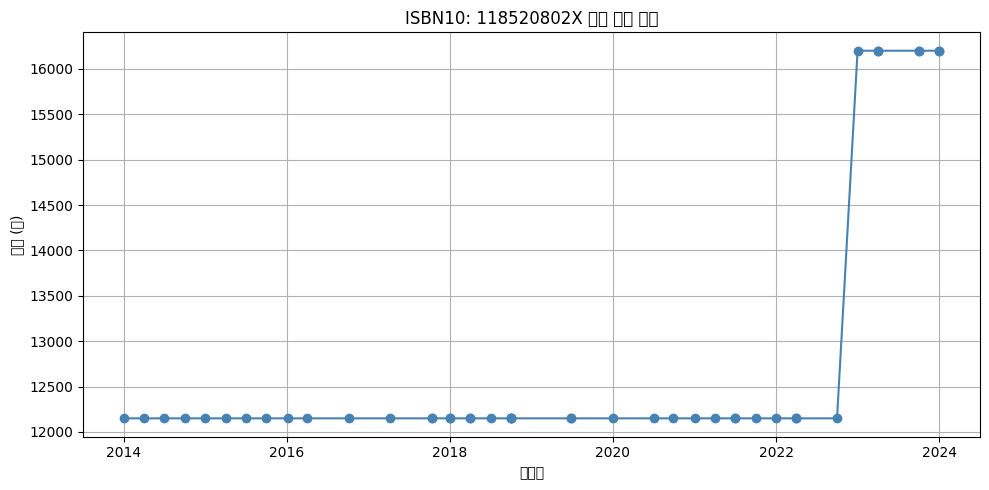

In [403]:
# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(book_history_sorted1['출판일'], book_history_sorted1['가격'], marker='o', color='steelblue')
plt.title("ISBN10: 118520802X 가격 변화 추이")
plt.xlabel("출판일")
plt.ylabel("가격 (원)")
plt.grid(True)
plt.tight_layout()
plt.show()

재출판이 되면서 가격이 상승했다. 하지만 약 10년간 가격 상승이 1번 있었기때문에 책 가격을 쉽게 올리지는 않는다는 것을 알 수 있다.

`-` 제목이 다른 ISBN 사례 `20053657`

In [396]:
isbn_target = "20053657"
book_history2 = merged_df[merged_df['ISBN10'] == isbn_target].copy()
book_history_sorted2 = book_history2.sort_values(by='출판일')
book_history_sorted2['출판일'] = pd.to_datetime(book_history_sorted2['출판일'], format="%Y년 %m월 %d일", errors='coerce')
book_history_sorted2

,파일경로,카테고리,제목,저자,출판사,출판일,별점,가격,쪽수,책크기,책소개,목차,판매지수,ISBN13,ISBN10,카테고리 분류,이벤트,배송료,카테고리ID
2568,001001001001007/book_3142355.html,요리일반,한국식품연감 2008-2009,편집부,농수축산신문,2008-10-30,0,120000,999쪽,"2,468g",식품 산업 연감록. 한국 식품 산업의 업종별 현황 및 전망과 식품인들에게 필요한 관...,None,None,9772005365705,20053657,None,[],무료배송,001001001001007
2766,001001001001007/book_4381252.html,요리일반,한국식품연감 2010-2011,편집부 저,농수축산신문,2010-11-10,0,120000,588쪽,"1,910g",『한국식품연감 2011』. 식품 산업 연감록. 한국 식품 산업의 업종별 현황 및 전...,None,None,9772005365705,20053657,None,[],무료배송,001001001001007
2384,001001001001007/book_6661345.html,요리일반,한국식품연감 2012-2013,편집부 저,HNCOM,2012-11-10,0,120000,590쪽,188*254*35mm,우리나라 식품산업의 현황과 전망을 한눈에 파악할 수 있는 연감. 우리 식탁을 책임지...,None,None,9772005365707,20053657,None,[],무료배송,001001001001007
2973,001001001001007/book_15401587.html,요리일반,한국식품연감 2014-2015,편집부 저,HNCOM,2014-11-15,0,120000,"1,059쪽",184*257*60mm,우리나라 식품산업의 현황과 전망을 한눈에 파악할 수 있는 연감. 우리 식탁을 책임지...,None,None,9772005365705,20053657,None,[],무료배송,001001001001007
2680,001001001001007/book_23451586.html,요리일반,한국식품연감 2015-2016,편집부 저,HNCOM,2015-11-25,0,120000,967쪽,192*265*40mm,우리나라 식품산업의 현황과 전망을 한눈에 파악할 수 있는 연감. 우리 식탁을 책임지...,None,None,9772005365705,20053657,None,[],무료배송,001001001001007
2072,001001001001007/book_34764176.html,요리일반,한국식품연감 2016-2017,편집부 저,HNCOM,2016-11-25,10,120000,"1,048쪽",190*256*60mm,None,특집특집 1 : 식품유통업계 HMR 봄특집 2-1 : Asia Fruit Logis...,None,9772005365705,20053657,None,[],무료배송,001001001001007
2839,001001001001007/book_57555998.html,요리일반,한국식품연감 2017-2018,편집부 저,HNCOM,2017-11-28,0,120000,"1,213쪽",188*255*60mm,None,특집특집 1 : 2016 식품산업 원료소비 실태조사특집 2-1 : 2017 가정간편...,None,9772005365705,20053657,None,[],무료배송,001001001001007
2769,001001001001007/book_68676710.html,요리일반,한국식품연감 2018-2019,편집부 저,HNCOM,2018-12-05,0,120000,"1,263쪽",188*257*60mm,None,특집특집1 : 학교급식총론특집2 : 2018 농식품 소비트렌드 -다양해지는 마트매대...,None,9772005365002,20053657,None,[],무료배송,001001001001007
2690,001001001001007/book_84782141.html,요리일반,한국식품연감 2019-2020,편집부 저,HNCOM,2019-12-02,0,120000,"1,401쪽",188*257*80mm,None,특집특집1 : 쌀 산업 위기 돌파할 KEYWORD특집2 : 2019 상반기 수입 농...,None,9772005365002,20053657,None,[],무료배송,001001001001007
2240,001001001001007/book_95932232.html,요리일반,한국식품연감 2020-2021,편집부 저,HNCOM,2020-12-02,0,120000,"1,333쪽",188*257*80mm,None,특집특집1 : 코로나19와 소비즈 생활 영향 및 전망특집2 : 코로나 19가 가져온...,None,9772005365002,20053657,None,[],무료배송,001001001001007


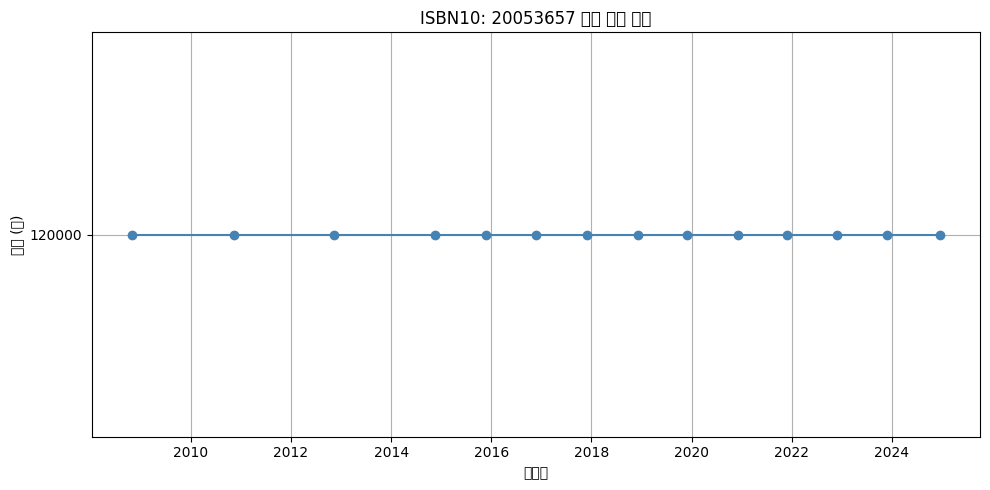

In [405]:
# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(book_history_sorted2['출판일'], book_history_sorted2['가격'], marker='o', color='steelblue')
plt.title("ISBN10: 20053657 가격 변화 추이")
plt.xlabel("출판일")
plt.ylabel("가격 (원)")
plt.grid(True)
plt.tight_layout()
plt.show()

역시 이 책 또한 16년간 책 가격이 동결로 책 가격이 쉽게 오르지 않는다는 것을 보여준다.

`-` 결론: 책 가격은 재출판시에 쉽게 올리지 않는다.

In [ ]:
---

## 3-2. 배송료

`-` **Data**

In [411]:
df['배송료'].value_counts()

배송료
2,500원    16281
무료배송       8772
3,000원        1
Name: count, dtype: int64

`-` **Resonance**

3000원이 있긴 하지만 대표적으로 무료배송, 2500원으로 나뉜다. 어떤 기준같은 게 있을까?

In [434]:
price1 = df[df['배송료'] == '2,500원']['가격'].str.replace('원', '').str.replace(',', '').astype(int)
price1.describe()

count    16281.000000
mean     10806.088692
std       2787.109710
min        900.000000
25%       8910.000000
50%      11520.000000
75%      13320.000000
max      16000.000000
Name: 가격, dtype: float64

In [433]:
price2 = df[df['배송료'] == '무료배송']['가격'].str.replace('원', '').str.replace(',', '').astype(int)
price2.describe()

count      8772.000000
mean      23649.394665
std       15998.428563
min        5000.000000
25%       16200.000000
50%       18900.000000
75%       25200.000000
max      475000.000000
Name: 가격, dtype: float64

`-` 책 가격이 높으면 무료배송인 경향이 있다.

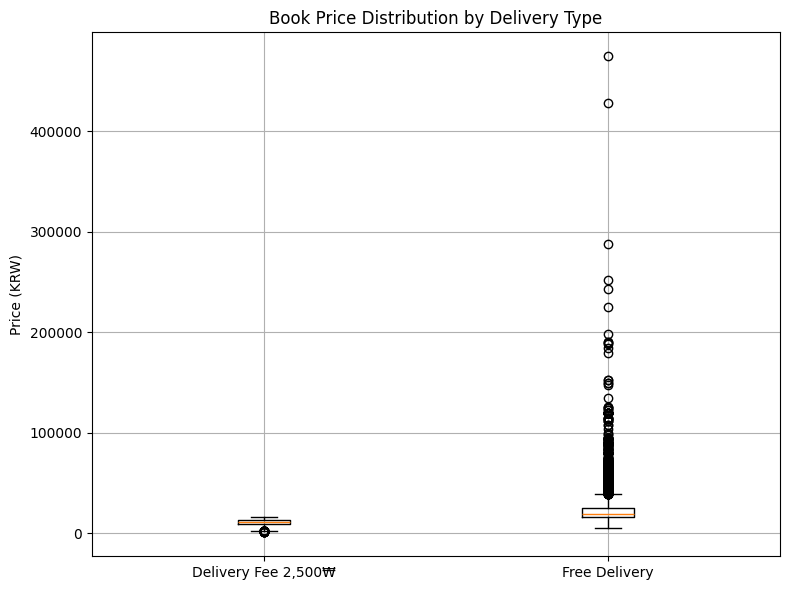

In [437]:
# Boxplot with English labels
plt.figure(figsize=(8, 6))
plt.boxplot([price1, price2], labels=["Delivery Fee 2,500₩", "Free Delivery"])
plt.ylabel("Price (KRW)")
plt.title("Book Price Distribution by Delivery Type")
plt.grid(True)
plt.tight_layout()
plt.show()

`-` Problem: 그럼 얼마부터 배송비가 2500원인지가 궁금하다

/tmp/ipykernel_245015/75160784.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  배송별비율 = df.groupby(['가격구간', '배송료']).size().unstack().fillna(0)


<Axes: xlabel='가격구간'>

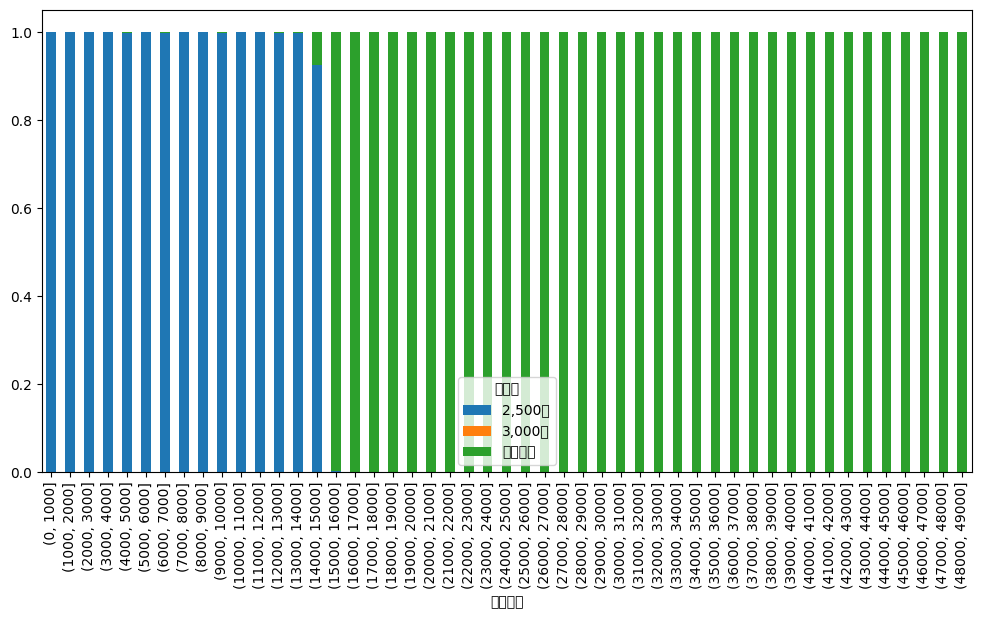

In [440]:
df['가격_int'] = df['가격'].str.replace('원', '').str.replace(',', '').astype(float)
bins = list(range(0, 50000, 1000))
df['가격구간'] = pd.cut(df['가격_int'], bins)
배송별비율 = df.groupby(['가격구간', '배송료']).size().unstack().fillna(0)
(배송별비율.T / 배송별비율.sum(axis=1)).T.plot(kind='bar', stacked=True, figsize=(12,6))

`-` 결론 : 대략 14800원정도 이상이면 2500원 이상이다.

---

## 3-3. 출판사 브랜드 신뢰도 분석

여러 카테고리에서 출판하는 출판사가 있는지 확인해봤다.

In [228]:
# 평균별점 0점 이상 필터링
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['평균별점'] >= 0]

# 출판사별로 몇 개 카테고리에서 8점 이상인지 count
high_rated_counts = (
    high_rated.groupby('출판사')
    .agg(카테고리수=('카테고리', 'nunique'))
    .reset_index()
    .sort_values('카테고리수', ascending=False)
)

# 필요하면 해당 출판사들의 평균별점/카테고리도 함께 보기 위해 merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='출판사')
high_rated_merged[high_rated_merged['카테고리수'] == 11]

,출판사,카테고리수,평균별점,리뷰개수,카테고리
0,리스컴,11,9.266667,12,차/술/음료
1,리스컴,11,9.306250,16,요리일반
2,리스컴,11,9.398649,74,생활요리
3,리스컴,11,9.407317,41,개인요리책
4,리스컴,11,9.200000,59,상황별요리
5,리스컴,11,9.168750,48,메뉴별/나라별요리
6,리스컴,11,9.233333,24,홈베이킹/베이커리
7,리스컴,11,9.576923,13,임신/출산
8,리스컴,11,9.560000,15,육아
9,리스컴,11,9.341667,12,자녀교육


In [229]:
# 평균별점 0점 이상 필터링
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['평균별점'] >= 0]

# 출판사별로 몇 개 카테고리에서 8점 이상인지 count
high_rated_counts = (
    high_rated.groupby('출판사')
    .agg(카테고리수=('카테고리', 'nunique'))
    .reset_index()
    .sort_values('카테고리수', ascending=False)
)

# 필요하면 해당 출판사들의 평균별점/카테고리도 함께 보기 위해 merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='출판사')
high_rated_merged[high_rated_merged['카테고리수'] == 7]

,출판사,카테고리수,평균별점,리뷰개수,카테고리
11,그린쿡,7,9.538462,13,차/술/음료
12,그린쿡,7,9.470000,10,요리일반
13,그린쿡,7,9.284211,19,생활요리
14,그린쿡,7,9.338889,18,개인요리책
15,그린쿡,7,8.876923,13,상황별요리
16,그린쿡,7,9.177143,35,메뉴별/나라별요리
17,그린쿡,7,9.303333,30,홈베이킹/베이커리
18,동아일보사,7,8.787500,16,생활요리
19,동아일보사,7,8.910000,10,개인요리책
20,동아일보사,7,9.130769,13,상황별요리


`-` Resonance

응? 대부분 평점이 엄청 높네?

In [227]:
# 출판사별 별점 저장 리스트
publisher_ratings = []

for cat, df in dfs_rated.items():
    temp = df.copy()
    
    # 출판사 결측 제거 및 정리
    temp = temp[temp['출판사'].notnull()]
    
    # 출판사별 평균 별점 계산
    grp = temp.groupby('출판사')['별점'].agg(['mean', 'count']).reset_index()
    grp['카테고리'] = cat  # 카테고리 정보 추가
    
    publisher_ratings.append(grp)

# 모든 카테고리 통합
pub_rating_df = pd.concat(publisher_ratings, ignore_index=True)

# 이름 정리
pub_rating_df.columns = ['출판사', '평균별점', '리뷰개수', '카테고리']

# 리뷰 수 10개 이상만 필터링 (신뢰성 확보)
filtered_pub_rating_df = pub_rating_df[pub_rating_df['리뷰개수'] >= 10]

# 평균별점 내림차순 정렬
pub_rating_sorted = filtered_pub_rating_df.sort_values("평균별점", ascending=False)

pub_rating_sorted

,출판사,평균별점,리뷰개수,카테고리
5085,체인지업,9.900000,12,자녀교육
4705,시대인,9.885714,14,자녀교육
3613,시대인,9.869231,13,육아
4304,동양북스(동양books),9.866667,18,자녀교육
4267,더메이커,9.841667,12,자녀교육
...,...,...,...,...
739,클라이닉스,7.760000,10,요리일반
2127,IFAD(이프애드),7.477273,22,홈베이킹/베이커리
5731,중앙m&b,7.421429,14,집/살림
5585,서울문화사,6.875000,12,집/살림


`-` Insight

다양한 카테고리에서 출판하는 출판사들이 평점이 대체적으로 높다.

In [185]:
# 평균별점 8점 이상 필터링
high_rated = filtered_pub_rating_df[filtered_pub_rating_df['평균별점'] >= 8]

# 출판사별로 몇 개 카테고리에서 8점 이상인지 count
high_rated_counts = (
    high_rated.groupby('출판사')
    .agg(카테고리수=('카테고리', 'nunique'))
    .reset_index()
    .sort_values('카테고리수', ascending=False)
)

# 필요하면 해당 출판사들의 평균별점/카테고리도 함께 보기 위해 merge
high_rated_merged = pd.merge(high_rated_counts, high_rated, on='출판사')
eleven_df = high_rated_merged[high_rated_merged['카테고리수'] >= 5]
eleven_df.groupby('출판사').agg({'평균별점':'mean'}).reset_index()

,출판사,평균별점
0,경향미디어,9.483405
1,경향비피,9.626501
2,그리고책,9.161116
3,그린쿡,9.284137
4,길벗,9.621711
5,나무수,9.319587
6,동아일보사,8.945743
7,레시피팩토리(단행),9.682654
8,리스컴,9.356132
9,미호,9.092096


`-` 출판사의 품질 보증

단순한 인기 책이 아니라, 꾸준한 만족을 만들어내는 제작 시스템이 있음을 증명합니다.

---

## 3-4. 도서 정보로 보는 사회현상 탐구

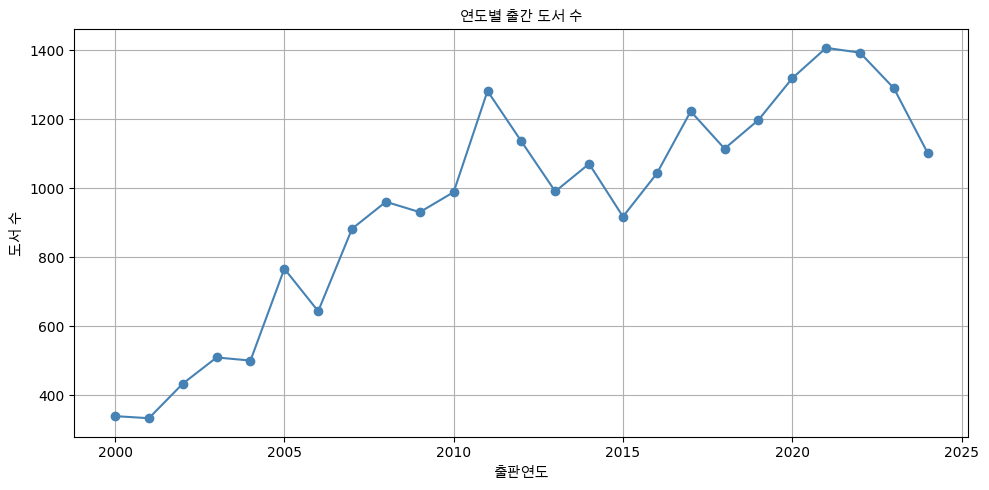

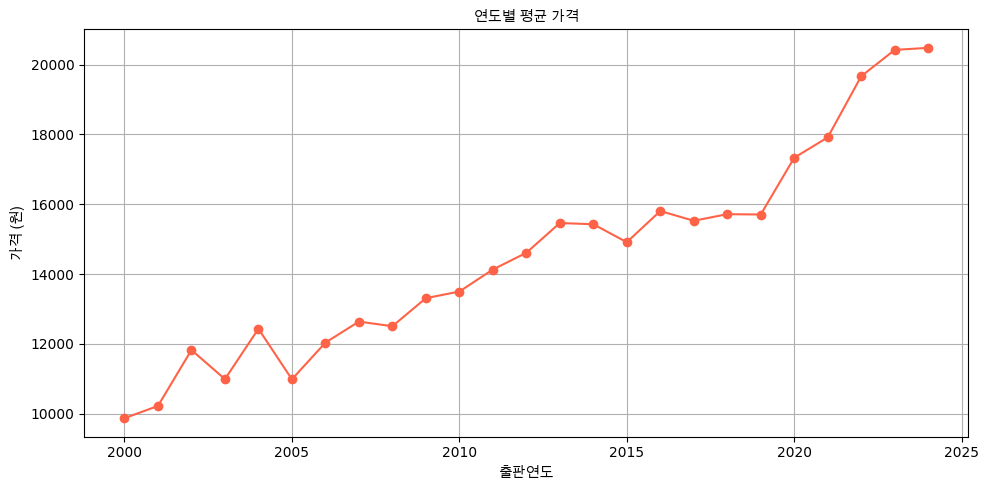

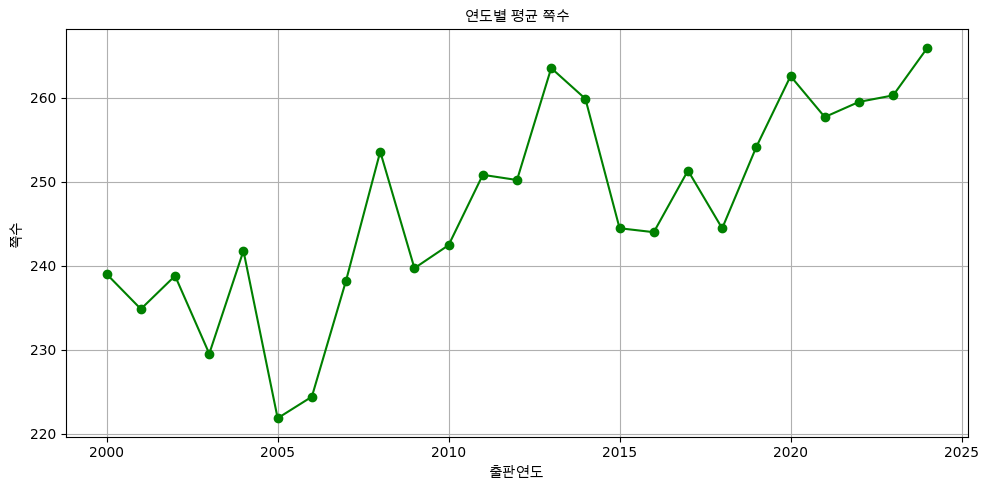

In [232]:
# suppress font logs
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# ✅ 폰트 설정
font_path = "./Arial Unicode.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# ✅ 통합 전처리
records = []

for cat, df in dfs_grouped.items():
    df = df.copy()
    df['출판연도'] = df['출판일'].astype(str).str.extract(r'(\d{4})')[0]
    df['출판연도'] = pd.to_numeric(df['출판연도'], errors='coerce')
    df['가격'] = pd.to_numeric(df['가격'].astype(str).str.replace(",", "").str.replace("원", ""), errors='coerce')
    df['쪽수'] = pd.to_numeric(df['쪽수'].astype(str).str.extract(r'(\d+)')[0], errors='coerce')

    # 책 면적 추출
    def calc_area(text):
        try:
            parts = text.replace("mm", "").split("*")
            if len(parts) >= 2:
                return int(parts[0]) * int(parts[1])
        except:
            return None
        return None

    df['책면적'] = df['책크기'].astype(str).apply(calc_area)
    df['카테고리'] = cat
    records.append(df[['출판연도', '가격', '쪽수', '책면적', '카테고리']])

combined_df = pd.concat(records, ignore_index=True)
combined_df = combined_df.dropna(subset=['출판연도'])
combined_df['출판연도'] = combined_df['출판연도'].astype(int)
# ✅ 2000년 이후, 2025년 제외
combined_df = combined_df[(combined_df['출판연도'] >= 2000) & (combined_df['출판연도'] != 2025)]


# ✅ 연도별 집계
trend_df = (
    combined_df
    .groupby('출판연도')
    .agg({
        '가격': 'mean',
        '쪽수': 'mean',
        '책면적': 'mean',
        '카테고리': 'count'  # 출간 도서 수
    })
    .rename(columns={'카테고리': '출간도서수'})
    .reset_index()
)

# ✅ 시각화 함수
def plot_trend(x, y, title, ylabel, color):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, marker='o', color=color)
    plt.title(title, fontproperties=font_prop)
    plt.xlabel("출판연도", fontproperties=font_prop)
    plt.ylabel(ylabel, fontproperties=font_prop)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 그래프 그리기
plot_trend(trend_df['출판연도'], trend_df['출간도서수'], "연도별 출간 도서 수", "도서 수", 'steelblue')
plot_trend(trend_df['출판연도'], trend_df['가격'], "연도별 평균 가격", "가격 (원)", 'tomato')
plot_trend(trend_df['출판연도'], trend_df['쪽수'], "연도별 평균 쪽수", "쪽수", 'green')

`-` 2020년 이후 출판 도서 수 감소의 원인
1. 코로나19 팬데믹
- 공급망 충격: 종이 부족, 인쇄소 운영 차질 등으로 물리적 출판 지연
- 출판사 운영 축소: 소규모 출판사나 독립 출판의 활동이 위축
- 신간 기획 중단: 출판 업계 전반의 불확실성 증가 -> 신간 계획 축소
2. 전자책 및 오디오북 확산
- 종이책 출간은 줄었지만, 디지털 콘텐츠로 대체되는 경향
3. 도서정가제 개정 이슈
- 할인 제한 등으로 도서 시장 위축 -> 신간 출판 부담 증가

`-` 쪽수 변화

1. 2000년대 이전: 평균 쪽수의 큰 변동
- 데이터 수가 적어서 변동이 심하다.
2. 2000년대 이후: 평균 쪽수가 230~270쪽 범위에서 서서히 증가중이다.
- 디지털 시대에 오히려 더 풍부한 정보 제공이나 시리즈물 경향으로 쪽수가 늘어난 것으로 추정.

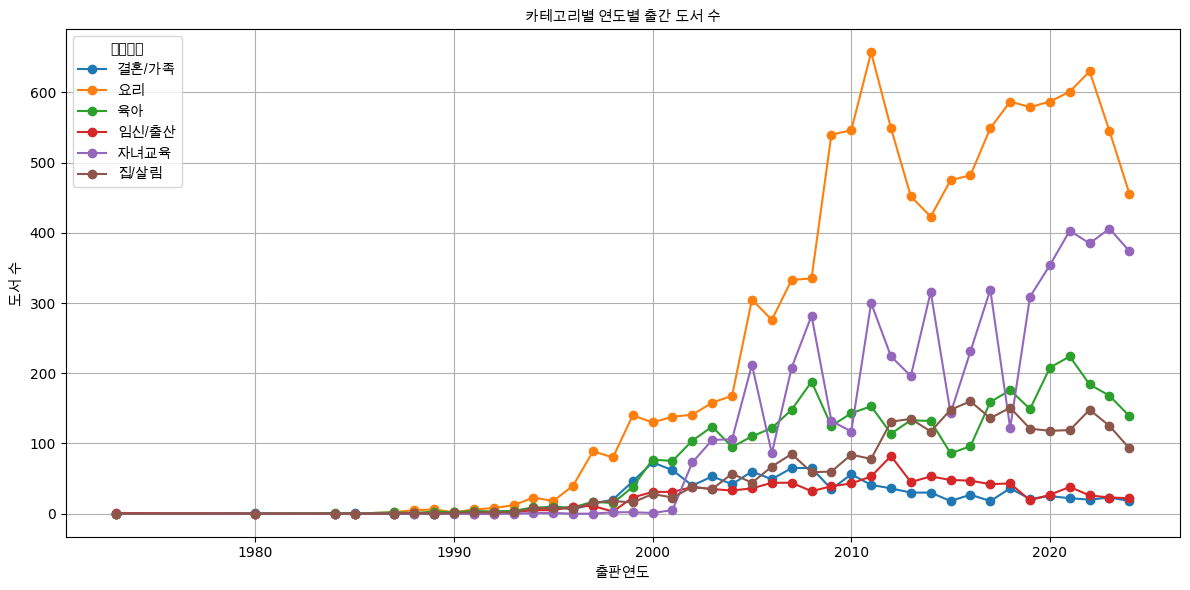

In [230]:
# ✅ 연도별 카테고리별 도서 수 집계
category_year_counts = (
    combined_df
    .groupby(['출판연도', '카테고리'])
    .size()
    .reset_index(name='도서수')
)

# ✅ 피벗 테이블로 변환: index=연도, columns=카테고리
pivot_df = category_year_counts.pivot(index='출판연도', columns='카테고리', values='도서수').fillna(0)

# ✅ 시각화: 여러 카테고리 선 그래프
plt.figure(figsize=(12, 6))
for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col)

plt.title("카테고리별 연도별 출간 도서 수", fontproperties=font_prop)
plt.xlabel("출판연도", fontproperties=font_prop)
plt.ylabel("도서 수", fontproperties=font_prop)
plt.legend(title="카테고리", prop=font_prop, loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**2023년 이후로 지금까지 출간 도서의 수는 급감중이다.**

1. 출판 시장의 위축: 디지털 콘텐츠 소비로 전환
2. 출판사 구조조정과 폐업 증가 -> 실제로 2023 ~ 2024년 한국 출판사 등록 수는 줄고 있음.
3. 소비자 심리 변화 -> 코로나 이후 독서 관심 이탈

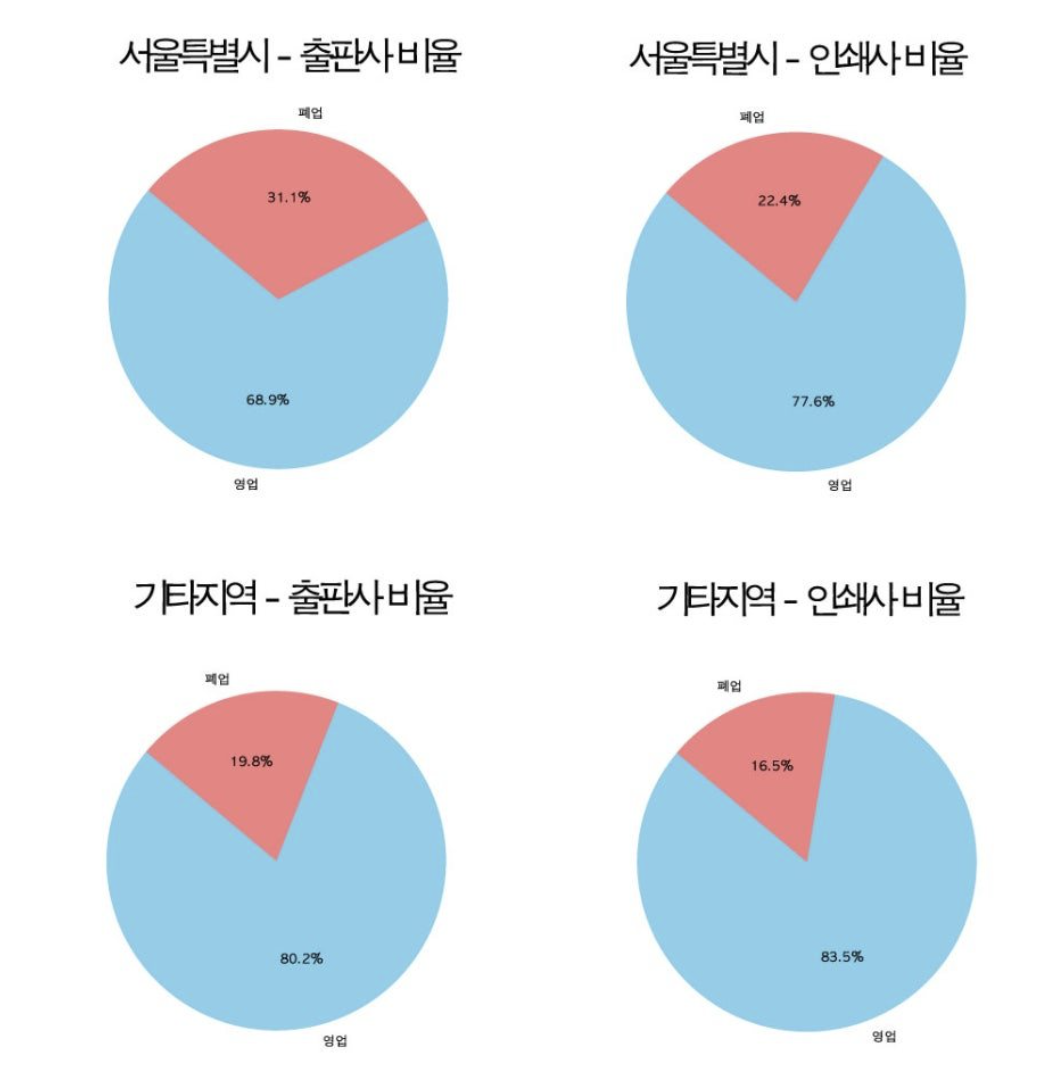

**2005년 ~ 2010년 요리 도서 출간 급증의 이유**

1. 웰빙 트렌드와 건강에 대한 관심 증가
2. 요리 관련 TV 프로그램이 인기를 끌면서 요리에 대한 대중의 관심이 높아졌다.

**책 가격이 꾸준히 오르는 이유**

1. 인플레이션
 - 한국은행 소비자물가(CPI) 기준 2000년 대비 2023년 약 35~40% 상승
 - 책값은 실제로 약 2배정도 올랐는데 이것만으로는 설명되지 않는다.
2. 책의 구성 변화
 - 컬러 인쇄 / 사진 중심 구성 -> 제작 단가 상승 -> 정가 상승
 - 고급 제본 -> 양장 or 종이를 더 좋은 것을 사용 -> 판매가 인상
 - 패키지 구성 -> 책 + 워크북 + 카드 등 세트화 경향 증가
3. 타겟 독자 변화
 - 요리/자녀교육/홈베이킹은 대중 전체가 아닌 `몰입 독자` 중심 판매
 - 출판사는 대량보다는 고정 구매층을 위한 프리미엄 전략을 취함
4. 출간 수 감소로 인한 단가 상승
 - 출판사는 전체 판매량이 줄고 있기에 수익을 맞추기 위해 권당 가격을 올리는 경향이 있음

**책의 페이지 수가 늘어나는 이유**

1. 깊이 있는 책에 대한 수요 집중
 - 디지털 콘텐츠에서 얕은 지식은 충분히 얻을 수 있게 되므로 돈 주고 사는 책은 **깊이 있게 설명하는 책**이 되어야한다.
2. 저자 중심 콘텐츠 강화 -> 자전적 서술 증가
 - 전문가 브랜딩을 위해서 한 권 안에 경험 + 해석 + 팁 + FAQ + 칼럼까지 다 넣다보니 페이지 수가 늘어남
 - 실제로 요리책도 요즘은 레시피보다 서사 중심 구성이 많음
3. 편집 트렌드 변화
 - 독서 피로도를 줄이기 위해 편집이 넓은 여백 + 큰 글자 + 많은 사진 중심으로 변화
 - 이로 인해 물리적 쪽수는 늘어나지만 실제 텍스트 양은 비슷할 수 있음

---

## 3-5. 자녀교육의 평균 페이지 증가

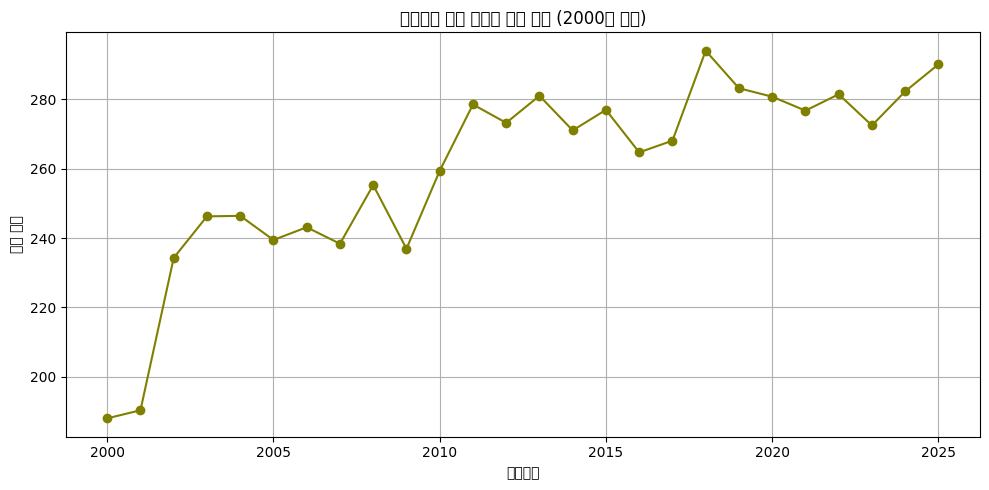

In [210]:
# suppress font logs
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import matplotlib.font_manager as fm
font_path = "Arial Unicode.ttf"
font_prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

df = dfs_renamed['자녀교육'].copy()

# 출판연도 추출
df['출판연도'] = df['출판일'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

# 쪽수 숫자로 변환
df['쪽수'] = df['쪽수'].astype(str).str.extract(r'(\d+)')[0].astype(float)

# ✅ 2000년 이후 도서만 필터링
df = df[df['출판연도'] >= 2000]

# 연도별 평균 쪽수 집계
trend = df.groupby('출판연도')['쪽수'].mean().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(trend['출판연도'], trend['쪽수'], marker='o', color='olive')
plt.title("자녀교육 분야 연도별 평균 쪽수 (2000년 이후)")
plt.xlabel("출판연도")
plt.ylabel("평균 쪽수")
plt.grid(True)
plt.tight_layout()
plt.show()

📚 자녀교육서 평균 페이지 증가가 시사하는 것
1. 부모들의 정보 욕구 증가
현대 사회에서 부모들은 더 많은 정보를 바탕으로 자녀를 양육하려는 경향이 강해졌습니다.

교육 방식, 뇌 발달, 심리학, 진로, 디지털 리터러시 등 다양한 하위 주제가 포함되며 책의 분량도 자연스럽게 증가합니다.

2. 양육의 전문화·세분화
과거에는 '훈육'이나 '생활 습관' 중심이던 교육서가,

지금은 발달 심리, 언어 자극, 감정 코칭, 창의성 교육, 코딩교육 등 다양한 분야로 세분화.

이로 인해 1권에 담아야 할 정보량이 많아지고, 페이지 수도 늘어납니다.

3. 출판 경향의 변화
시리즈가 아닌 단권 완결형 종합 교육서가 늘어나는 추세일 수 있음.

예전엔 얇은 책 여러 권이던 것이, 요즘은 두꺼운 종합서로 통합되는 구조.

4. 사회적 불안과 경쟁 심화
교육 환경이 경쟁적으로 변하면서, 부모는 더 많은 대비를 하려 함.

예: 조기교육, 사교육, 진학 전략 등 복잡해진 교육 현실을 반영.

5. 디지털 시대에 오히려 강화된 '활자 교육' 콘텐츠
아이를 디지털 미디어로부터 지키기 위해, 부모는 책 중심의 교육 콘텐츠를 더 선호함.

따라서 오프라인 콘텐츠의 깊이와 신뢰성 확보를 위해 두꺼워지는 경향도 있음.

---

## 3-6. 자녀교육 책은 2000년 이전에 6권밖에 없다?

In [233]:
df = dfs_renamed['자녀교육'].copy()

# 출판연도 추출
df['출판연도'] = df['출판일'].astype(str).str.extract(r'(\d{4})')[0]
df['출판연도'] = pd.to_numeric(df['출판연도'], errors='coerce')

# 전체 도서 수
total_count = len(df)

# 2000년 이전 도서 필터링
before_2000_df = df[df['출판연도'] < 2000]
before_2000_count = before_2000_df.shape[0]

# 결과 출력
print(f"전체 도서 수: {total_count}권")
print(f"2000년 이전 도서 수: {before_2000_count}권")
print("\n📚 2000년 이전 도서 제목 목록:")
print(before_2000_df[['출판연도', '제목']].sort_values(by='출판연도'))

전체 도서 수: 5661권
2000년 이전 도서 수: 6권

📚 2000년 이전 도서 제목 목록:
        출판연도                      제목
2726  1994.0             어머니의 피아노 교육
19    1995.0                신세대 심층분석
1492  1998.0           일기쓰기 어떻게 시작할까
3223  1998.0  유대인은 EQ로 시작하여 IQ로 승리한다
1953  1999.0        아이에게 행복을 주는 비결 1
4157  1999.0        아이에게 행복을 주는 비결 2


🔍 원인:
과거에는 자녀교육이 ‘출판 카테고리’로 뚜렷하게 분리되지 않음
→ 훈육, 가정생활, 가정학 등의 범주로 존재했지만, 지금과 같은 전문화된 교육 콘텐츠는 많지 않았음.

자녀교육이 사회적 화두가 된 것은 2000년대 이후
→ 입시경쟁, 조기교육, 창의성 교육 등 현대적 개념이 강화되며 폭발적으로 출판됨.

패러다임이 빠르게 바뀌는 분야
→ 시대 흐름에 맞지 않는 과거 책은 도태되고 재출간되지 않음.